## For better Regression
### 1) model selection : 가장 error가 적게 나오는 model 선택
### 2) feature engineering : 가장 error가 적게 나오는 feature를 recursive feature elimination을 통해 추출
### 3) gridserach :가장 error가 적게 나오는 hyperparmeter 추출

### 4) 1),2),3)의 결과 합쳐서 예측 Data 제출

## 1. import and load data
1) import packages

**Data fields**

ID : 집을 구분하는 번호

date : 집을 구매한 날짜

price : 집의 가격(Target variable)

bedrooms : 침실의 수

bathrooms : 화장실의 수

sqft_living : 주거 공간의 평방 피트(면적)

sqft_lot : 부지의 평방 피트(면적)

floors : 집의 층 수

waterfront : 집의 전방에 강이 흐르는지 유무 (a.k.a. 리버뷰)

view : 집이 얼마나 좋아 보이는지의 정도

condition : 집의 전반적인 상태

grade : King County grading 시스템 기준으로 매긴 집의 등급

sqft_above : 지하실을 제외한 평방 피트(면적)

sqft_basement : 지하실의 평방 피트(면적)

yr_built : 지어진 년도

yr_renovated : 집을 재건축한 년도

zipcode : 우편번호

lat : 위도

long : 경도

sqft_living15 : 2015년 기준 주거 공간의 평방 피트(면적, 집을 재건축했다면, 변화가 있을 수 있음)

sqft_lot15 : 2015년 기준 부지의 평방 피트(면적, 집을 재건축했다면, 변화가 있을 수 있음)

In [457]:
import warnings
warnings.filterwarnings("ignore")

import os
from os.path import join

import pandas as pd
import numpy as np

import missingno as msno

from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.model_selection import KFold, cross_val_score,train_test_split,GridSearchCV
from sklearn.metrics import mean_squared_error as rmse
from sklearn.preprocessing import StandardScaler

import shap
import eli5
from eli5.sklearn import PermutationImportance
import gc

import xgboost as xgb
import lightgbm as lgb
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor



import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import seaborn as sns

2) Load train and test data

In [461]:
dir_path = os.getenv('HOME') + '/aiffel/kaggle_kakr_housing/data'
train_data_path = join(dir_path, 'train.csv')
sub_data_path = join(dir_path, 'test.csv')
train = pd.read_csv(train_data_path)
test = pd.read_csv(sub_data_path)
print(train.shape, test.shape)

(15035, 21) (6468, 20)


In [459]:
trainset= pd.DataFrame(train)
trainset.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15'],
      dtype='object')

## 2. Preprocessing
1) date revision

2)detach label(price) column as **'y'**

3)delete id

4)normalization as log(1+x) for skewed data

### 5) feature engineering using recursive feature elimination

## correlation of features

In [414]:
# fig = plt.figure(figsize=(30,10))
# fig.add_subplot(131)
# ax1 = sns.regplot(train['zipcode'], y)
# fig.add_subplot(132)
# ax2 = sns.regplot(train['long'], y)
# fig.add_subplot(133)
# ax3 = sns.regplot(train['lat'], y)


## Feature engineering using RFE

## 1) making a lot of features derived from baseline features

1) concatenate train and test set

In [462]:
 df = pd.concat([train, test],ignore_index=True)
 df



,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21498,21498,20140626T000000,NaN,3,1.75,1500,11968,1.0,0,0,...,6,1500,0,2014,0,98010,47.3095,-122.002,1320,11303
21499,21499,20150126T000000,NaN,3,2.00,1490,1126,3.0,0,0,...,8,1490,0,2014,0,98144,47.5699,-122.288,1400,1230
21500,21500,20150219T000000,NaN,3,2.50,1310,1294,2.0,0,0,...,8,1180,130,2008,0,98116,47.5773,-122.409,1330,1265
21501,21501,20140623T000000,NaN,2,0.75,1020,1350,2.0,0,0,...,7,1020,0,2009,0,98144,47.5944,-122.299,1020,2007


In [463]:

# feature interactions
df['room_count'] = df['bedrooms'] + df['bathrooms']
df['sqft_living_per_rooms'] = df['sqft_living'] / (df['room_count']+1)
df['sqft_lot_per_rooms'] = df['sqft_lot'] / (df['room_count']+1)
df['room_per_floors'] = df['room_count'] / df['floors']
df['sqft_living_per_floors'] = df['sqft_living'] / df['floors']
df['sqft_lot_per_floors'] = df['sqft_lot'] / df['floors']
df['sqft_living_per_bedrooms'] = df['sqft_living'] / (df['bedrooms']+1)
df['sqft_lot_per_bedrooms'] = df['sqft_lot'] / (df['bedrooms']+1)
df['bedroom_per_floors'] = df['bedrooms'] / df['floors']
df['sqft_lot-D-sqft_living'] = df['sqft_lot'] - df['sqft_living']
df['sqft_lot-R-sqft_living'] = df['sqft_lot'] / df['sqft_living']
df['sqft_living15-D-sqft_living'] = df['sqft_living15'] - df['sqft_living']
df['sqft_living15-R-sqft_living'] = df['sqft_living15'] / df['sqft_living']
df['sqft_lot15-D-sqft_lot'] = df['sqft_lot15'] - df['sqft_lot']
df['sqft_lot15-R-sqft_lot'] = df['sqft_lot15'] / df['sqft_lot']
df['rooms_mul']=df['bedrooms']*df['bathrooms']
df['total_score']=df['condition']+df['grade']+df['view']

# binary features
df['has_basement'] = (df['sqft_basement']>0).astype('uint8')
df['has_attic'] = ((df['floors'] % 1) != 0).astype('uint8')

# one hot encode
#df['zipcode'] = df['zipcode'].astype('str')
#df = pd.get_dummies(df)

# log transform target
df['price'] = np.log1p(df['price'])

train = df.loc[:len(train)-1]
test = df.loc[len(train):]

del df; gc.collect();


2), 3) 4) 등등

In [417]:
train['date'] = train['date'].apply(lambda i: i[:6]).astype(int)
y = train['price']
del train['price']
del train['id']
test['date'] = test['date'].apply(lambda i: i[:6]).astype(int)

del test['price']
del test['id']


In [418]:
train

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,...,sqft_lot-D-sqft_living,sqft_lot-R-sqft_living,sqft_living15-D-sqft_living,sqft_living15-R-sqft_living,sqft_lot15-D-sqft_lot,sqft_lot15-R-sqft_lot,rooms_mul,total_score,has_basement,has_attic
0,201410,3,1.00,1180,5650,1.0,0,0,3,7,...,4470,4.788136,160,1.135593,0,1.000000,3.00,10,0,0
1,201502,2,1.00,770,10000,1.0,0,0,3,6,...,9230,12.987013,1950,3.532468,-1938,0.806200,2.00,9,0,0
2,201502,3,2.00,1680,8080,1.0,0,0,3,8,...,6400,4.809524,120,1.071429,-577,0.928589,6.00,11,0,0
3,201406,3,2.25,1715,6819,2.0,0,0,3,7,...,5104,3.976093,523,1.304956,0,1.000000,6.75,10,0,0
4,201501,3,1.50,1060,9711,1.0,0,0,3,7,...,8651,9.161321,590,1.556604,0,1.000000,4.50,10,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15030,201410,4,2.50,2520,6023,2.0,0,0,3,9,...,3503,2.390079,0,1.000000,0,1.000000,10.00,12,0,0
15031,201503,4,3.50,3510,7200,2.0,0,0,3,9,...,3690,2.051282,-1460,0.584046,-1000,0.861111,14.00,12,1,0
15032,201405,3,2.50,1530,1131,3.0,0,0,3,8,...,-399,0.739216,0,1.000000,378,1.334218,7.50,11,0,0
15033,201502,4,2.50,2310,5813,2.0,0,0,3,8,...,3503,2.516450,-480,0.792208,1387,1.238603,10.00,11,0,0


In [419]:
test = test.reset_index(drop=True)

In [420]:
#y = np.log1p(y)
#y

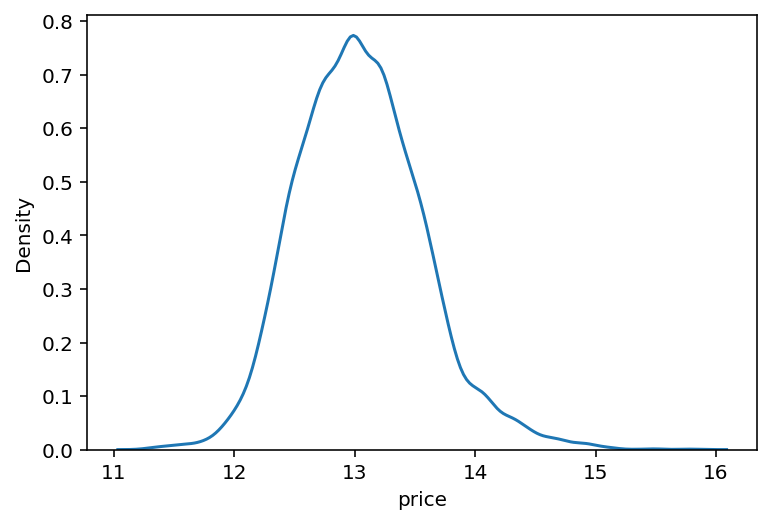

In [421]:
sns.kdeplot(y)
plt.show()

### Now, rmse computing function (using expm1 

In [422]:
def rmse_expm1(pred, true):
    return -np.sqrt(np.mean((np.expm1(pred)-np.expm1(true))**2))

In [426]:
def rfe(x_data, y_data, method, ratio=0.9, min_feats=15):
    feats = x_data.columns.tolist()
    archive = pd.DataFrame(columns=['model', 'n_feats', 'feats', 'score'])
    while True:
        model = LGBMRegressor(objective='regression', num_iterations=10**5)
        x_train, x_val, y_train, y_val = train_test_split(x_data[feats], y_data, random_state=0)
        model.fit(x_train, y_train, eval_set=[(x_val, y_val)], early_stopping_rounds=100, verbose=False)
        val_pred = model.predict(x_val)
        score = rmse(val_pred, y_val)##rmse score
        n_feats = len(feats)
        print(n_feats, score)
        archive = archive.append({'model': model, 'n_feats': n_feats, 'feats': feats, 'score': score}, ignore_index=True)
        if method == 'basic':
            feat_imp = pd.Series(model.feature_importances_, index=feats).sort_values(ascending=False)
        elif method == 'perm':
            perm = PermutationImportance(model, random_state=0).fit(x_val, y_val)
            feat_imp = pd.Series(perm.feature_importances_, index=feats).sort_values(ascending=False)
        elif method == 'shap':
            explainer = shap.TreeExplainer(model)
            shap_values = explainer.shap_values(x_data[feats])
            feat_imp = pd.Series(np.abs(shap_values).mean(axis=0), index=feats).sort_values(ascending=False)
        next_n_feats = int(n_feats * ratio)
        if next_n_feats < min_feats:
            break
        else:
            feats = feat_imp.iloc[:next_n_feats].index.tolist()
    return archive

feats = [col for col in train.columns if col != 'price']
len(feats)

38

## 3) Ensemble for 4 regressors(models)
1) def get_scores : return the RMSE score given model and training data
2) 

In [424]:
random_state = 2021
gboost = GradientBoostingRegressor(random_state=random_state)
xgboost = XGBRegressor(random_state=random_state)
lightgbm = LGBMRegressor(random_state=random_state)
rdforest = RandomForestRegressor(random_state=random_state)

models = [gboost, xgboost, lightgbm, rdforest]

### baseline score of the model...


In [425]:
def get_scores(models, train, y):
    # 답안 작성
    df = {}
    for model in models:
    # 모델 이름 획득
        model_name = model.__class__.__name__

        X_train, X_test, y_train, y_test = train_test_split(train, y, random_state=random_state, test_size=0.2)

        # 모델 학습
        model.fit(X_train, y_train)

        # 예측
        y_pred = model.predict(X_test)

        # 예측 결과의 rmse값 저장
        df[model_name] = rmse(y_test, y_pred)
        
        score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=False)
	
    return score_df
    

get_scores(models, train, y)

,RMSE
GradientBoostingRegressor,0.034254
RandomForestRegressor,0.030663
XGBRegressor,0.030180
LGBMRegressor,0.028415


## LGBMRegressor looks the best with Score 0.028415

## Now, let's delete feature diminishing RMSLE!!!


## recursive feature elimination

1) basic feature importance

In [427]:
x_train = train[feats]
basic_archive = rfe(x_train, y, 'basic')

38 0.026680881864981205
34 0.02692749699318558
30 0.027792396628710195
27 0.028259085277861477
24 0.028722476450174207
21 0.028530374145761397
18 0.02955883816218873
16 0.029345849000609193


2) permutation importance

In [428]:
x_train = train[feats]
perm_archive = rfe(x_train, y, 'perm')

38 0.026680881864981205
34 0.026548455926486605
30 0.026647179345071704
27 0.025981376486582056
24 0.025950866907487078
21 0.02586078471632124
18 0.026022814005404748
16 0.026438263708397674


3) Shap

In [429]:
%%time
shap_archive = rfe(x_train, y, 'shap')

38 0.026680881864981205
34 0.02673095940168126
30 0.026632120876107425
27 0.0266487050343618
24 0.02756784690387407
21 0.027732342364856905
18 0.02784315798176738
16 0.027625075124978346
CPU times: user 7min 39s, sys: 453 ms, total: 7min 40s
Wall time: 1min 56s


### at 21 feature in 'permutation importance' feature elimination,
### The RMSLE score is the smallest.

In [444]:

min_index = perm_archive['score'].argmin()
filtered_column = perm_archive['feats'][min_index]
fin_score = perm_archive['score'][min_index]
print(filtered_column)
#type(filtered_column)

['lat', 'sqft_living', 'long', 'total_score', 'grade', 'yr_built', 'sqft_living15', 'sqft_above', 'zipcode', 'date', 'waterfront', 'sqft_lot', 'sqft_lot_per_bedrooms', 'sqft_lot_per_floors', 'yr_renovated', 'sqft_lot15', 'sqft_living_per_bedrooms', 'rooms_mul', 'sqft_lot-R-sqft_living', 'sqft_lot-D-sqft_living', 'bathrooms']


### Extract column for the least error score!

In [442]:
train = train[filtered_column]
test = test[filtered_column]
train.head()

,lat,sqft_living,long,total_score,grade,yr_built,sqft_living15,sqft_above,zipcode,date,...,sqft_lot,sqft_lot_per_bedrooms,sqft_lot_per_floors,yr_renovated,sqft_lot15,sqft_living_per_bedrooms,rooms_mul,sqft_lot-R-sqft_living,sqft_lot-D-sqft_living,bathrooms
0,47.5112,1180,-122.257,10,7,1955,1340,1180,98178,201410,...,5650,1412.500000,5650.0,0,5650,295.000000,3.00,4.788136,4470,1.00
1,47.7379,770,-122.233,9,6,1933,2720,770,98028,201502,...,10000,3333.333333,10000.0,0,8062,256.666667,2.00,12.987013,9230,1.00
2,47.6168,1680,-122.045,11,8,1987,1800,1680,98074,201502,...,8080,2020.000000,8080.0,0,7503,420.000000,6.00,4.809524,6400,2.00
3,47.3097,1715,-122.327,10,7,1995,2238,1715,98003,201406,...,6819,1704.750000,3409.5,0,6819,428.750000,6.75,3.976093,5104,2.25
4,47.4095,1060,-122.315,10,7,1963,1650,1060,98198,201501,...,9711,2427.750000,9711.0,0,9711,265.000000,4.50,9.161321,8651,1.50


## 4 GridSerach (hyperparmeter tuning)
1) def myGridSearch(model,train,y,param_grid)

 given **hyperparmeter settings**, return **dataframe sorted by score**

In [445]:
def my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5):
    grid_model = GridSearchCV(model, param_grid=param_grid, \
                        scoring='neg_mean_squared_error', \
                        cv=5, verbose=verbose, n_jobs=n_jobs)

    grid_model.fit(train, y)
    
    
    params = grid_model.cv_results_['params']
    score = grid_model.cv_results_['mean_test_score']
    
    results = pd.DataFrame(params)
    results['score'] = score
    
    results['RMSLE'] = np.sqrt(-1 * results['score'])
    results = results.sort_values('RMSLE',axis=0, ascending = True)
    
    return results

In [446]:
param_grid = {
    "n_estimators" :[300,400],
    "max_depth": [20,30],
    "learning_rate":[0.01,0.1,0.05],
    "boosting_type":['gbdt','dart'],
    "feature_fraction":[0.7],
    "bagging_fraction":[0.7]
    
}

### Hyperparameter tuning

1)LGBM

In [266]:
model = LGBMRegressor(random_state=random_state)
my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  31 tasks      | elapsed:   17.8s
[Parallel(n_jobs=5)]: Done 120 out of 120 | elapsed:  2.1min finished


[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


,bagging_fraction,boosting_type,feature_fraction,learning_rate,max_depth,n_estimators,score,RMSLE
11,0.7,gbdt,0.7,0.05,30,400,-0.026180,0.161802
9,0.7,gbdt,0.7,0.05,20,400,-0.026245,0.162003
10,0.7,gbdt,0.7,0.05,30,300,-0.026395,0.162465
8,0.7,gbdt,0.7,0.05,20,300,-0.026464,0.162679
6,0.7,gbdt,0.7,0.10,30,300,-0.026497,0.162778
7,0.7,gbdt,0.7,0.10,30,400,-0.026584,0.163046
4,0.7,gbdt,0.7,0.10,20,300,-0.026641,0.163220
5,0.7,gbdt,0.7,0.10,20,400,-0.026661,0.163281
1,0.7,gbdt,0.7,0.01,20,400,-0.030437,0.174463
3,0.7,gbdt,0.7,0.01,30,400,-0.030440,0.174471


2) Random Forest -> exclude for bad score

In [70]:
# param_grid = {
#     "n_estimators" :[200,300],
#     "max_depth": [20,25,30]
    
# }
# model = RandomForestRegressor(random_state=random_state)
# my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  30 out of  30 | elapsed:  2.2min finished


,max_depth,n_estimators,score,RMSLE
5,30,300,-0.079034,0.281129
3,25,300,-0.079061,0.281179
1,20,300,-0.079095,0.281238
4,30,200,-0.079129,0.281298
2,25,200,-0.079165,0.281362
0,20,200,-0.079193,0.281413


## 5. Data Submission
 def save_submission 
    
    given model_name and RMSLE score, 
    
    1)load sample_submission file
    2) update prediction,
    3)save it submission
    

In [451]:
def save_submission(model, train, y, test, model_name, rmsle):
    
    model.fit(train, y)
    prediction = model.predict(test)
    prediction = np.expm1(prediction)
    
    data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'
    submission_path = join(data_dir, 'sample_submission.csv')
    submission = pd.read_csv(submission_path)
    submission['price'] = prediction
    submission_csv_path = '{}/submission_{}_RMSLE_{:.3f}.csv'.format(data_dir, model_name, rmsle)
    submission.to_csv(submission_csv_path, index=False)
    print('{} saved!'.format(submission_csv_path))
    

In [455]:
model = LGBMRegressor(boosting_type='gbdt',
                      max_depth=30,
                      learning_rate=0.05,
                      n_estimators=400,
                      subsample=0.7, #bagging fraction
                      colsample_bytree=0.7, # feature fraction
                        random_state=random_state+1)
save_submission(model, train, y, test, 'lgbm', rmsle=fin_score)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
/aiffel/aiffel/kaggle_kakr_housing/data/submission_lgbm_RMSLE_0.026.csv saved!


# Public score : 109395.27840
# Private score : 111491.15769